In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

from xgboost import XGBRegressor


Read the data

In [112]:
df = pd.read_csv("TASK-ML-INTERN.csv")

# 1. Data Exploration and Preprocessing

In [113]:
df.head(2)

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0


In [114]:
df.columns

Index(['hsi_id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '439', '440', '441', '442', '443', '444', '445', '446', '447',
       'vomitoxin_ppb'],
      dtype='object', length=450)

In [115]:
print("data shape is:", df.shape)

data shape is: (500, 450)


In [116]:
# Check missing values
print("Number of nulls in the data: ",df.isnull().sum().sum())

Number of nulls in the data:  0


correlation matrix between spectral features and vomitoxin levels

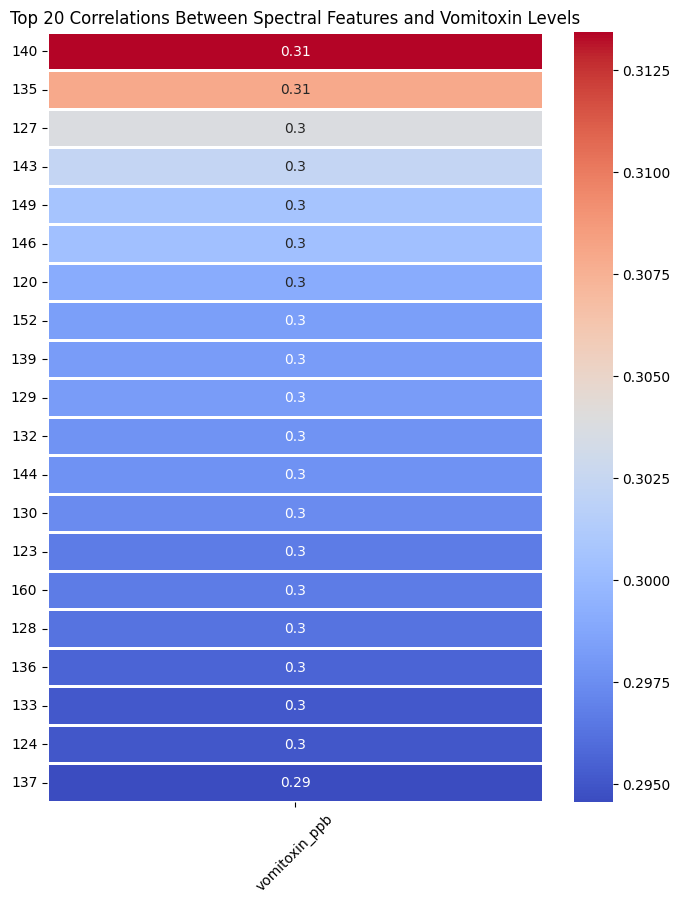

In [117]:
corr = df.iloc[:, 1:].corr()
top_features = corr[['vomitoxin_ppb']].abs().sort_values(by='vomitoxin_ppb', ascending=False)[1:21]

plt.figure(figsize=(8, 10))
sns.heatmap(top_features, cmap="coolwarm", annot=True, linewidths=.9)

plt.title("Top 20 Correlations Between Spectral Features and Vomitoxin Levels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [118]:
print("Statistics for spectral data: ")
df_numeric = df.iloc[:, 1:]
df_numeric.describe().sample(8, axis=1)

Statistics for spectral data: 


,73,277,217,62,14,178,321,104
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.357864,0.796143,0.764553,0.343894,0.373274,0.720177,0.810645,0.571823
std,0.038903,0.064314,0.064923,0.037119,0.039658,0.063280,0.063957,0.053095
min,0.244409,0.585881,0.529822,0.233521,0.251627,0.488970,0.617878,0.369673
25%,0.330768,0.748948,0.719590,0.320432,0.343477,0.677437,0.763939,0.539615
50%,0.358806,0.801199,0.771194,0.344337,0.374047,0.723747,0.817113,0.572330
75%,0.383613,0.843922,0.808847,0.367991,0.406848,0.762673,0.857672,0.604917
max,0.504459,1.019377,0.996031,0.472644,0.462200,0.964256,1.033757,0.805507


Let's check take a closer look at distribution of vomitoxin

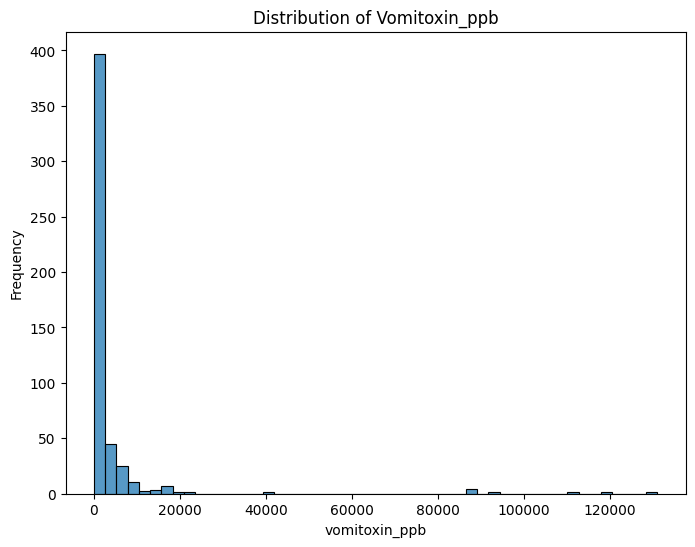

In [119]:
def vomitoxin_distribution(df):
    plt.figure(figsize=(8,6))
    sns.histplot(df['vomitoxin_ppb'], bins=50)
    plt.title("Distribution of Vomitoxin_ppb")
    plt.xlabel("vomitoxin_ppb")
    plt.ylabel("Frequency")
    plt.show()
vomitoxin_distribution(df)

## Summary of EDA
**Feature Range:**
* Most spectral features (0-447) have values between ~0.25 and 0.95
* The target value has a very large range: 0 to 131,000.

**STD**
* Most spectral features have a small standard deviation (~0.04 to 0.05).
* The target has an extremely high standard deviation (13,095.8), indicating extreme outliers.

I will standardize the data using Robust Scaling as it is best for skewed data and handling outliers

## Data Preprocessing
Standardization using RobustScaler

In [120]:
# Define the numerical data
df_numeric = df.iloc[:, 1:]

# Apply robust scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled_data, columns=df_numeric.columns)

In [121]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,-0.471754,-0.614758,-0.331444,-0.687694,-0.412053,-0.619432,-0.671677,-0.738327,-0.694250,-0.357189,...,-0.443092,-0.392221,-0.404747,-0.522698,-0.639301,-0.681864,-0.414882,-0.621163,-0.552176,0.3840
1,-0.477261,-0.532721,-0.415801,-0.382775,-0.257789,-0.296352,-0.398205,-0.463133,-0.282433,-0.383551,...,-0.789744,-0.670959,-0.581353,-0.648621,-0.580916,-0.886725,-0.602612,-0.635992,-0.759386,0.3200
2,-0.860893,-0.958838,-0.802895,-0.674437,-0.726285,-0.828402,-0.957156,-0.907592,-0.919845,-0.882493,...,-0.802369,-1.056911,-1.105314,-0.918183,-0.910885,-1.172776,-1.096014,-0.969917,-1.079300,0.5120
3,0.282733,0.410739,0.377480,0.451291,0.578200,0.639012,0.705565,0.403491,0.305638,0.360693,...,-0.014180,-0.208540,-0.111704,-0.188798,0.100433,-0.072865,-0.011119,0.123366,-0.164237,0.5120
4,0.490724,0.598879,0.458992,0.824232,0.608718,0.523451,0.706028,0.580005,0.459226,0.602730,...,0.347993,0.373622,0.220951,0.263946,0.249551,0.000619,0.418169,0.198818,0.083815,-0.1792


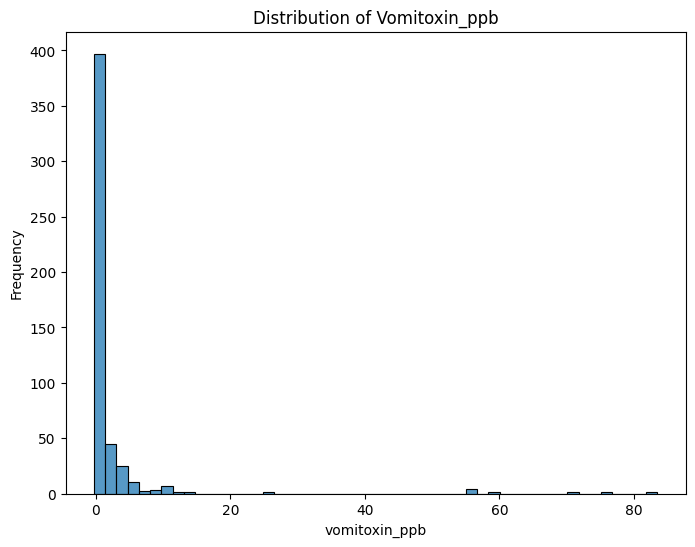

In [122]:
vomitoxin_distribution(df_scaled)

# 3. Dimensionality reduction

## PCA

In [123]:
X = df_scaled.drop(columns='vomitoxin_ppb')
y = df_scaled['vomitoxin_ppb']

# Apply PCA
pca = PCA(10)
X_pca = pca.fit_transform(X)

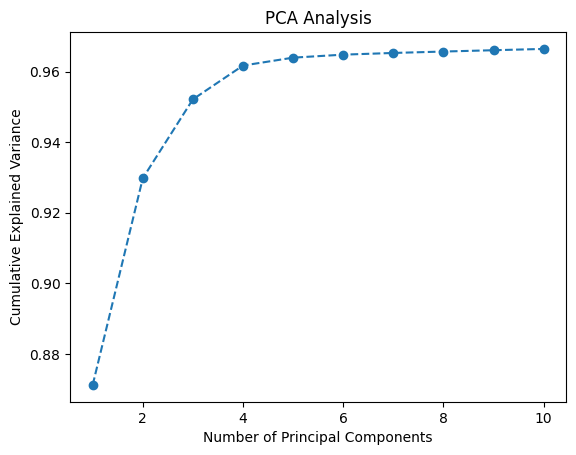

In [124]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 11), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Analysis")
plt.show()

### PCA Analysis Results:
* the first 4 components explain ~95% of the variance
* the first 6 components explain ~97% of the variance
* Additional components do not contribute much new information

**conclusion**: to simplify model and reduce overfitting: we will use 4 components.

In [125]:
# Select the first 4 components
X_pca_selected = X_pca[:, :4]

# Convert PCA results into dataframe
df_pca = pd.DataFrame(X_pca_selected)
df_pca.columns = [f"PC{i+1}" for i in range(X_pca_selected.shape[1])]
df_pca["vomitoxin_ppb"] = y
df_pca.head()

,PC1,PC2,PC3,PC4,vomitoxin_ppb
0,-10.267679,1.728454,1.640070,-1.483660,0.3840
1,-10.302097,1.708163,0.728565,-0.540083,0.3200
2,-21.996333,-3.871879,-3.496241,0.736015,0.5120
3,3.267876,1.149669,1.757566,0.992075,0.5120
4,9.048259,-1.099132,-1.113984,2.015256,-0.1792


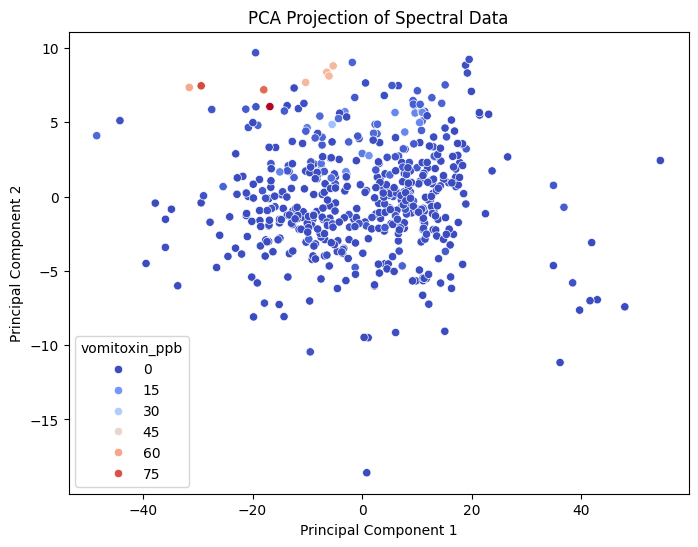

In [126]:
# Plot PCA Components
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['vomitoxin_ppb'], palette='coolwarm')
plt.title("PCA Projection of Spectral Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

high-toxin samples cluster together means PCA successfully captured important patterns.

# 3. Model Training

In [127]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### Random Forest

In [131]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

MAE: 1.4674, RMSE: 3.8087, R² Score: 0.8733


In [ ]:

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R² Score: {r2:.4f}")


MAE: 1.5510, RMSE: 5.4249, R² Score: 0.7430


# Feature explorations
- try PCA with 5 and 6 components
- try t-SNE
- Trying different deep learning models.